## Perturbative results

In [1]:
from scipy.io import loadmat

import matplotlib.pyplot as plt

mat_contents = loadmat('../../Matlab/Version_For_Ragheed/Polaron_Mu_0p4142_Nk_10_Self_Energy_Terms.mat')

dJUs_vector = mat_contents['objPol']['tdJ_grid'][0][0][0]
U12 = mat_contents['objPol']['U12'][0][0][0]
sigma0 = mat_contents['objPol']['fill_qm_corrected'][0][0][0]
sigma1 = mat_contents['objPol']['E0_Order_U12_sq_frohlich_only'][0][0][0]
sigma2 = mat_contents['objPol']['E0_Order_U12_sq_Beyond_Frohlich_only'][0][0][0]
en_vector = U12 * sigma0 + sigma1 + sigma2


In [2]:
# Compute the energy of the polaron in the limit of small U12

import numpy as np
import os
import utils
from grid import Grid
from params import Params
from gs import groundstate
from exc import excitations
from vert import vertices
from pert import perturbative
from plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt

config_path = "config.yml" 

output_dir = utils.create_output_dir()

config = utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]

N = config["physics"]["N"]
dJUs = np.arange(**config["lists"]["dJUs"])
muU = eval(config["physics"]["muU"])
UIB = config["physics"]["UIB"]
cutoff = config["physics"]["cutoff"]

grid = Grid(Lx, Ly)

omega0s = np.zeros(len(dJUs))
omega1s = np.zeros(len(dJUs))
omega2s = np.zeros(len(dJUs))
omegas = np.zeros((len(dJUs), 3))
for count in range(len(dJUs)):
    dJU = dJUs[count]
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    psi0 = gs.psi0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    Pert_Energy = pert.perturbative_energy(n0)
    omega0s[count] = Pert_Energy[0]
    omega1s[count] = Pert_Energy[1]
    omega2s[count] = Pert_Energy[2]

KeyboardInterrupt: 

In [2]:
import numpy as np
import os
import utils
from grid import Grid
from params import Params
from gs import groundstate
from exc import excitations
from vert import vertices
from pert import perturbative
from class_self_energy import Self_Energy
from class_io import IO
from plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt

config_path = "config.yml" 

output_dir = utils.create_output_dir()

config = utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]

N = config["physics"]["N"]
dJUs = np.arange(**config["lists"]["dJUs"])
muU = eval(config["physics"]["muU"])
# muU = 0.2
UIB = config["physics"]["UIB"]
cutoff = config["physics"]["cutoff"]

grid = Grid(Lx, Ly)

en_vector = np.linspace(0.01, 0.35, 120)

dJUs = np.arange(0.001, 0.35, 0.005)
omega0s = np.zeros(len(dJUs))
omega1s = np.zeros(len(dJUs))
omega2s = np.zeros(len(dJUs))

SE = np.zeros((7, len(en_vector)), dtype=np.complex128)
SEE = np.zeros((len(en_vector), len(dJUs)), dtype=np.complex128)
T11 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T12 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T21 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22 = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22_F = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
SE_SI = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)


for dJU_ind in range(0, 30):
    dJU = dJUs[dJU_ind]
    print(dJU)
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    psi0 = gs.psi0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    Pert_Energy = pert.perturbative_energy(n0)
    omega0s[dJU_ind] = Pert_Energy[0]
    omega1s[dJU_ind] = Pert_Energy[1]
    omega2s[dJU_ind] = Pert_Energy[2]

    for epol_ind in range(len(en_vector)):
        Epol = en_vector[epol_ind]
        self_energy = Self_Energy(Epol, grid, params, verts, omegaklambda)
        output = self_energy.calculate_self_energy()
        SE[:, epol_ind] = output

    T11[dJU_ind, :] = SE[1, :]
    T12[dJU_ind, :] = SE[2, :]
    T21[dJU_ind, :] = SE[3, :]
    T22[dJU_ind, :] = SE[4, :]
    T22_F[dJU_ind, :] = SE[5, :]
    SE_SI[dJU_ind, :] = SE[6, :]
    

io = IO()
io.save_to_hdf5_all(grid, params, dJUs, en_vector, omega0s, omega1s, omega2s, T11, T12, T21, T22, T22_F, SE_SI)

dOmega = en_vector[1] - en_vector[0]

plt.plot(en_vector, T11[dJU_ind, :], label='T11')
plt.plot(en_vector, T12[dJU_ind, :], label='T12')
plt.plot(en_vector, T21[dJU_ind, :], label='T21')
plt.plot(en_vector, T22[dJU_ind, :], label='T22')
plt.plot(en_vector, T22_F[dJU_ind, :], label='T22_F')
plt.legend()
plt.show()

eta = 0.001
SpectralFunc = dOmega * (-2) * np.imag(1./(en_vector - SE_SI[dJU_ind, :] + 1j * eta))
plt.plot(en_vector, SpectralFunc)

0.001
0.006
0.011
0.016
0.021
0.026000000000000002
0.031
0.036000000000000004
0.041
0.046
0.051000000000000004
0.056
0.061
0.066
0.07100000000000001
0.076
0.081
0.08600000000000001
0.091
0.096
0.101
0.106
0.111
0.116
0.121
0.126
0.131
0.136
0.14100000000000001
0.146


AttributeError: 'Grid' object has no attribute 'N'

In [42]:
dJU_ind = 21
plt.plot(en_vector, T11[dJU_ind, :], label='T11')
plt.plot(en_vector, T12[dJU_ind, :], label='T12')
plt.plot(en_vector, T21[dJU_ind, :], label='T21')
plt.plot(en_vector, T22[dJU_ind, :], label='T22')
plt.plot(en_vector, T22_F[dJU_ind, :], label='T22_F')
plt.legend()
plt.show()
eta = 0.001
SpectralFunc = dOmega * (-2) * np.imag(1./(en_vector - SE_SI[dJU_ind, :] + 1j * eta))
plt.plot(en_vector, SpectralFunc)

NameError: name 'T11' is not defined

29


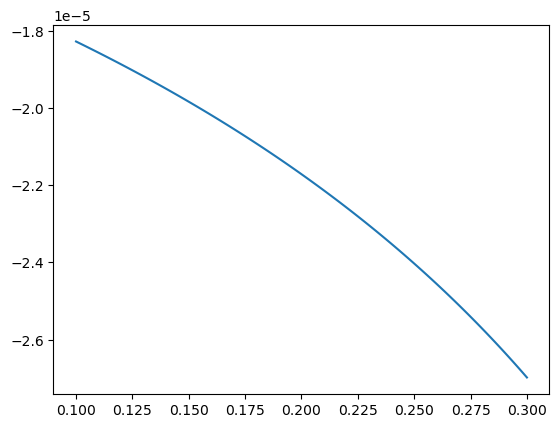

In [9]:
en_vector = np.linspace(0.1, 0.3, 100)
print(dJU_ind)

plt.plot(en_vector,T22_F[2, :], label='T22_F')
# plt.plot(en_vector, SpectralFunc)

In [62]:
import h5py
def save_to_hdf5_all(dJU_values, en_values, omega0s, omega1s, omega2s, T11_values, T12_values, T21_values, T22_values, T22_SE_values, SE_SI):
    filename = f'../data/spectral_funcs_UIB_{UIB:.2f}_Mu_{muU:.2f}_M_{grid.M}_N_{N}.hdf5'

    with h5py.File(filename, 'w') as f:
        # Save omega0s, omega1s, omega2s
        for i, dJU in enumerate(dJUs):
        # Create a group for this dJU value
            group = f.create_group(f'dJU_{dJU}')

            # Store the arrays in this group
            group.create_dataset('T11', data=T11[i, :])
            group.create_dataset('T12', data=T12[i, :])
            group.create_dataset('T21', data=T21[i, :])
            group.create_dataset('T22', data=T22[i, :])
            group.create_dataset('T22_SE', data=T22_F[i, :])
            group.create_dataset('SE_SI', data=SE_SI[i, :])
            group.create_dataset('en', data=en_vector)

        f.create_dataset('omega0s', data=omega0s)
        f.create_dataset('omega1s', data=omega1s)
        f.create_dataset('omega2s', data=omega2s)


        # Create attributes for your parameters
        f.attrs['UIB'] = UIB
        f.attrs['Lx'] = grid.Lx
        f.attrs['Ly'] = grid.Ly
        f.attrs['muU'] = muU

# Reading from file

0.2 10 10 0.41421356237309515 dict_keys(['dJU_0.001', 'dJU_0.011', 'dJU_0.020999999999999998', 'dJU_0.030999999999999996', 'dJU_0.040999999999999995', 'dJU_0.05099999999999999', 'dJU_0.06099999999999999', 'dJU_0.071', 'dJU_0.08099999999999999', 'dJU_0.09099999999999998', 'dJU_0.10099999999999998', 'dJU_0.11099999999999999', 'dJU_0.12099999999999998', 'dJU_0.13099999999999998', 'dJU_0.141', 'dJU_0.15099999999999997', 'dJU_0.16099999999999998', 'dJU_0.17099999999999999', 'dJU_0.18099999999999997', 'dJU_0.19099999999999998', 'dJU_0.20099999999999996', 'dJU_0.21099999999999997', 'dJU_0.22099999999999997', 'dJU_0.23099999999999996', 'dJU_0.24099999999999996', 'dJU_0.25099999999999995', 'dJU_0.26099999999999995', 'dJU_0.27099999999999996', 'dJU_0.28099999999999997', 'dJU_0.291'])


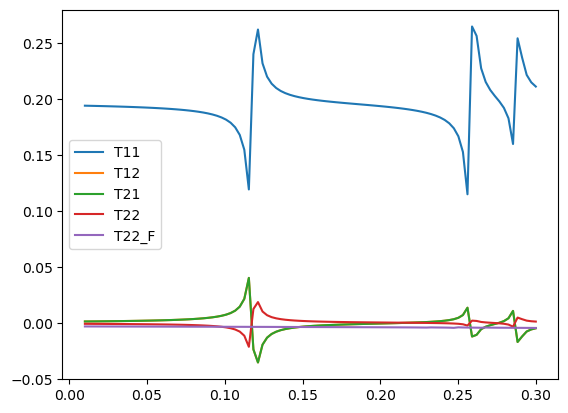

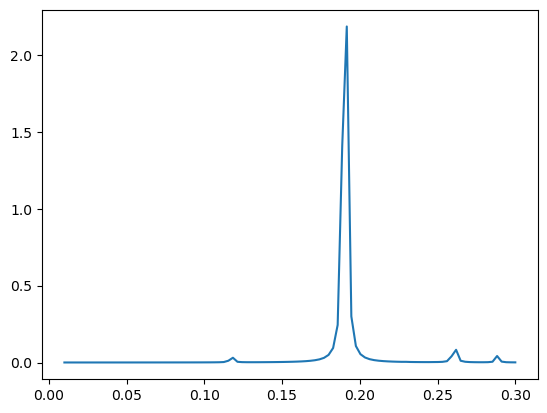

In [40]:
from class_io import IO
import numpy as np
from matplotlib import pyplot as plt
eta = 0.001

UIB, muU, M, N = 0.2, 0.41, 100, 7  # replace with your actual values

io = IO()
omega0s, omega1s, omega2s, data, UIB, Lx, Ly, muU = io.read_from_hdf5(UIB, muU, M, N)
print(UIB, Lx, Ly, muU, data.keys())
dJUs = np.arange(0.001, 0.3, 0.01)
en_vector = np.linspace(0.01, 0.3, 100)
dOmega = en_vector[1] - en_vector[0]
SE = np.zeros((7, len(en_vector)), dtype=np.complex128)
SEE = np.zeros((len(en_vector), len(dJUs)), dtype=np.complex128)
T11_read = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T12_read = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T21_read = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22_read = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
T22_SE_read = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
SE_SI_read = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
en = np.zeros((len(dJUs), len(en_vector)), dtype=np.complex128)
SpectralFuncs = np.zeros((len(dJUs), len(en_vector)))
for dJU_ind in range(0, 30):
    dJU = dJUs[dJU_ind]
    dJU_read = f'dJU_{dJU}'
    # dJU_read = 'dJU_0.5'  # replace with your actual dJU value
    T11_read[dJU_ind, :]  = data[dJU_read]['T11']
    T12_read[dJU_ind, :]  = data[dJU_read]['T12']
    T21_read[dJU_ind, :]  = data[dJU_read]['T21']
    T22_read[dJU_ind, :]  = data[dJU_read]['T22']
    T22_SE_read[dJU_ind, :]  = data[dJU_read]['T22_SE']
    SE_SI_read[dJU_ind, :]  = T11_read[dJU_ind, :] + T12_read[dJU_ind, :] + T21_read[dJU_ind, :] + T22_read[dJU_ind, :] + T22_SE_read[dJU_ind, :]
    en[dJU_ind, :]  = data[dJU_read]['en']
    SpectralFuncs[dJU_ind, :] = dOmega * (-2) * np.imag(1./(en_vector - SE_SI_read[dJU_ind, :] + 1j * eta))


# SpectralFunc = dOmega * (-2) * np.imag(1./(en_vector - SE_SI[dJU_ind, :] + 1j * eta))
# plt.plot(en_vector, SpectralFunc)


dJU_ind = 19
plt.plot(en_vector, T11_read[dJU_ind, :], label='T11')
plt.plot(en_vector, T12_read[dJU_ind, :], label='T12')
plt.plot(en_vector, T21_read[dJU_ind, :], label='T21')
plt.plot(en_vector, T22_read[dJU_ind, :], label='T22')
plt.plot(en_vector, T22_SE_read[dJU_ind, :], label='T22_F')
plt.legend()
plt.show()
plt.plot(en_vector, SpectralFuncs[dJU_ind, :], label='T11')

/Users/ragheed/micromamba/envs/boselattice/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ragheed/micromamba/envs/boselattice/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


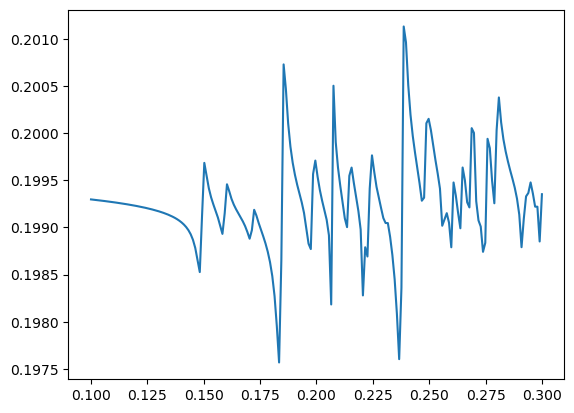

In [22]:
plt.plot(en_vector, SE_SI[10,:], label='omega0')

In [32]:
print(SpectralFuncs.shape)

(30, 100)


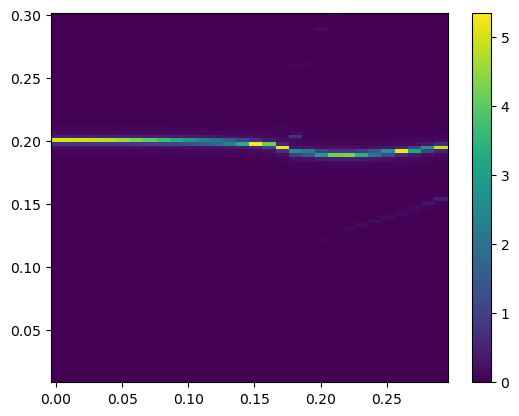

In [43]:
fig = plt.figure(); 
X, Y = np.meshgrid(dJUs, en_vector)
pc = plt.pcolormesh(X, Y, SpectralFuncs.T , shading='auto', cmap='viridis'); 
cbar = fig.colorbar(pc); plt.show()


In [41]:
eta = 0.001
SpectralFunc = dOmega * (-2) * np.imag(1./(en_vector - SEs + 1j * eta))
plt.plot(en_vector, SpectralFunc)


NameError: name 'SEs' is not defined

/Users/ragheed/micromamba/envs/boselattice/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ragheed/micromamba/envs/boselattice/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


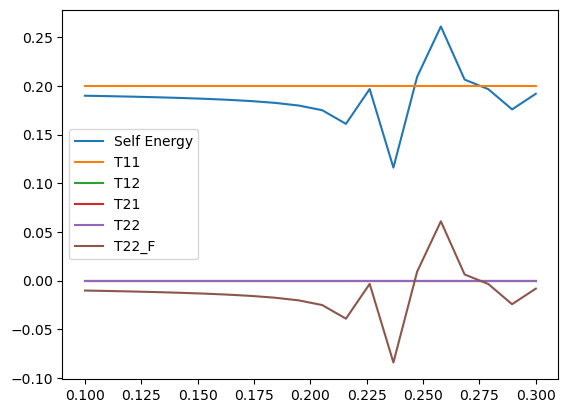

In [4]:
import numpy as np
import os
import utils
from grid import Grid
from params import Params
from gs import groundstate
from exc import excitations
from vert import vertices
from pert import perturbative
from class_self_energy import Self_Energy
from plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt

config_path = "config.yml" 

output_dir = utils.create_output_dir()

config = utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]

N = config["physics"]["N"]
dJUs = np.arange(**config["lists"]["dJUs"])
muU = eval(config["physics"]["muU"])
UIB = config["physics"]["UIB"]
cutoff = config["physics"]["cutoff"]

grid = Grid(Lx, Ly)

en_vector = np.linspace(0.1, 0.3, 20)

dJU = 0.179
params = Params(N, dJU, muU, UIB, cutoff)
gs = groundstate(params)
cns = gs.cns()
n0 = gs.n0(cns)
psi0 = gs.psi0(cns)
exc = excitations(grid, params, gs, cns)
uks, vks, omegaklambda = exc.calculate_matrices()
verts = vertices(grid, gs, uks, vks, cns, n0)

SE = np.zeros((len(en_vector), 7), dtype=np.complex128)

for epol_ind in range(len(en_vector)):
    Epol = en_vector[epol_ind]
    self_energy = Self_Energy(Epol, grid, params, verts, omegaklambda)
    output = self_energy.calculate_self_energy()
    SE[epol_ind] = output
    # print(Epol, SE[epol_ind])
    # pert = perturbative(grid, params, verts, omegaklambda)
    # Pert_Energy = pert.perturbative_energy(n0)
    # omega0s[count] = Pert_Energy[0]
    # omega1s[count] = Pert_Energy[1]
    # omega2s[count] = Pert_Energy[2]
SEs = SE[:, 6]
T11 = SE[:, 1]
T12 = SE[:, 2]
T21 = SE[:, 3]
T22 = SE[:, 4]
T22_F = SE[:, 5]

dOmega = en_vector[1] - en_vector[0]
eta = 0.001
SpectralFunc = dOmega * (-2) * np.imag(1./(en_vector - SEs + 1j * eta))

plt.plot(en_vector, SEs, label='Self Energy')
plt.plot(en_vector, T11, label='T11')
plt.plot(en_vector, T12, label='T12')
plt.plot(en_vector, T21, label='T21')
plt.plot(en_vector, T22, label='T22')
plt.plot(en_vector, T22_F, label='T22_F')
plt.legend()
plt.show()

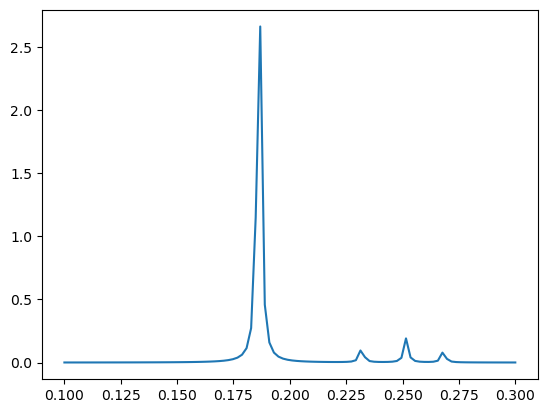

In [10]:
plt.plot(en_vector, SpectralFunc)

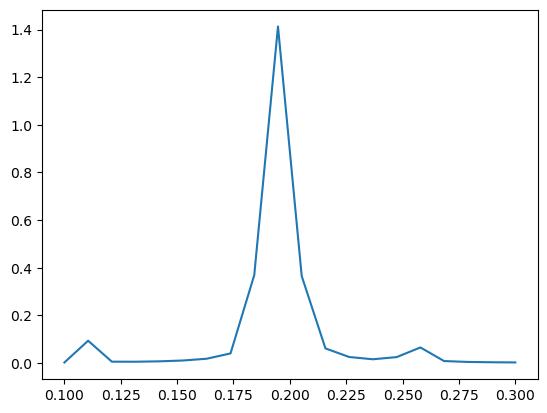

In [38]:
from scipy.linalg import inv
M = grid.M
dim = Lx * Ly * N
KXs = grid.KXs
KYs = grid.KYs
Us = np.zeros((dim, N))

PI1100 = np.zeros((dim, dim), dtype=complex)
Us = np.zeros((dim, dim), dtype=complex)
den_mat = np.zeros((dim, dim), dtype=complex)
en = np.zeros(len(en_vector), dtype=complex)
for epol_ind in range(1, len(en_vector)):
    Epol = en_vector[epol_ind]
    for lambda_ in range(N):
        for kx in range(Lx):
            for ky in range(Ly):
                for lambda1 in range(N):
                    for qx in range(Lx):
                        for qy in range(Ly):
                            indq = lambda1 * Lx * Ly + qx * Ly + qy
                            indk = lambda_ * Lx * Lx + kx * Ly + ky
                            Uelem = UIB * verts.U(kx, ky, lambda_, qx, qy, lambda1)
                            Den11 = Epol - omegaklambda[lambda1, qx, qy] - dJU * self_energy.epsI(KXs[qx], KYs[qy]) + eta * 1j
                            den_mat[indk, indq] = Den11
                            coeff = 1 / M
                            Den22 = Epol - omegaklambda[lambda1, qx, qy] - dJU * self_energy.epsI(KXs[qx], KYs[qy]) + eta * 1j
                            Us[indk, indq] = Uelem
                            PI1100[indk, indq] = coeff * Uelem / (Den11)
                            if lambda1 == 0:
                                PI1100[indk, indq] = 0

    IMat = np.eye(dim)
    inv11 = inv(IMat - PI1100)
    T1100 = inv11 @ Us
    en[epol_ind] = T1100[0,0]
SpectralFunc = dOmega * (-2) * np.imag(1./(en_vector - en + 1j * eta))
plt.plot(en_vector, SpectralFunc)
plt.show()

In [16]:
vec = np.random.rand(5)
np.tile(vec, (1, 3))
print(vec)
vec_matrix = np.tile(vec, (5, 1))
print(vec_matrix.T)

[0.95043513 0.11827831 0.04392862 0.23390984 0.17255055]
[[0.95043513 0.95043513 0.95043513 0.95043513 0.95043513]
 [0.11827831 0.11827831 0.11827831 0.11827831 0.11827831]
 [0.04392862 0.04392862 0.04392862 0.04392862 0.04392862]
 [0.23390984 0.23390984 0.23390984 0.23390984 0.23390984]
 [0.17255055 0.17255055 0.17255055 0.17255055 0.17255055]]


In [12]:
# Stack arrays in sequence horizontally (column wise).
data = np.column_stack((dJUs, omega0s, omega1s, omega2s))

# Save the data to a text file.
filename = f'../data/Perturbative_UIB_{UIB:.2f}_mu_{muU:.2f}.txt'
np.savetxt(filename, data, delimiter=",", header="dJUs, omega0s, omega1s, omega2s")

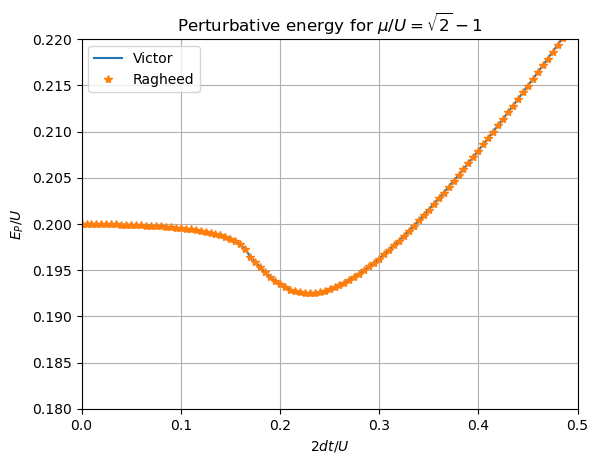

In [13]:
# Plot my results and those of Victor
# Load the data from the text file.
data = np.loadtxt(filename, delimiter=",")

# Split the data into separate arrays.
dJUs, omega0s, omega1s, omega2s = data.T

plt.plot(dJUs_vector, en_vector , label='Victor')
plt.plot(dJUs, omega0s + omega1s + omega2s, '*', label='Ragheed')
plt.xlabel(r"$2d t/U$")
plt.ylabel(r"$E_P/U$")
plt.title(r"Perturbative energy for $\mu/U = \sqrt{2}-1$")
plt.xlim([0, 0.5])
plt.ylim([0.18, 0.22])
plt.grid()
plt.legend()
plt.show()

In [55]:
# Write a code that calculates muU for a given sigma0

muU_qcorr = np.zeros(len(dJUs))
dJUmax = (np.sqrt(2) - 1)**2

def n0_corr(muU, dJU, UIB, cutoff):
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    eq = pert.sigma0(n0) / UIB
    return eq - 1

def findroot(mu_start, mu_step, dJU, UIB, cutoff):
    n_1 = n0_corr(mu_start, dJU, UIB, cutoff)
    n_2 = n0_corr(mu_start + mu_step, dJU, UIB, cutoff)
    
    if(n_1 * n_2 > 0):
        return findroot(mu_start + mu_step, mu_step, dJU, UIB, cutoff)
    else:
        n_mid = n0_corr(mu_start + mu_step / 2, dJU, UIB, cutoff)
        if(np.abs(n_mid) < 0.0001):
            return mu_start + mu_step / 2
        elif(n_mid * n_1 < 0):
            return findroot(mu_start, mu_step / 2, dJU, UIB, cutoff)
        else:
            return findroot(mu_start + mu_step / 2, mu_step / 2, dJU, UIB, cutoff)


# start with large values of dJU and decrease it 
for count in range(len(dJUs)):
    if(dJUs[count] < dJUmax):
        muU_qcorr[count] = np.sqrt(2) - 1
    else:
        dJU = dJUs[count]
        found = False
        mu_start = muU_qcorr[count] - 0.1
        mu_step = 0.05
        muU_qcorr[count] = findroot(mu_start, mu_step, dJU, UIB, cutoff)
        print("dJU = ", dJU, "muU = ", muU_qcorr[count])

plt.plot(dJUs, muU_qcorr, label=r"$\omega_{0}$")
plt.show()



dJU =  0.17500000000000002 muU =  0.4225
dJU =  0.18 muU =  0.41624999999999995
dJU =  0.185 muU =  0.41312499999999996
dJU =  0.19 muU =  0.4115625
dJU =  0.195 muU =  0.41039062499999995
dJU =  0.2 muU =  0.40765625
dJU =  0.20500000000000002 muU =  0.40609375000000003
dJU =  0.21 muU =  0.40375
dJU =  0.215 muU =  0.40140625
dJU =  0.22 muU =  0.399453125
dJU =  0.225 muU =  0.397109375
dJU =  0.23 muU =  0.39476562499999995
dJU =  0.23500000000000001 muU =  0.392421875
dJU =  0.24 muU =  0.390078125
dJU =  0.245 muU =  0.387734375
dJU =  0.25 muU =  0.385390625
dJU =  0.255 muU =  0.38304687499999995
dJU =  0.26 muU =  0.3803125
dJU =  0.265 muU =  0.37796875
dJU =  0.27 muU =  0.3754296875
dJU =  0.275 muU =  0.372890625
dJU =  0.28 muU =  0.37035156249999995
dJU =  0.28500000000000003 muU =  0.3678125
dJU =  0.29 muU =  0.365078125
dJU =  0.295 muU =  0.36234375
dJU =  0.3 muU =  0.3598046875
dJU =  0.305 muU =  0.3570703125
dJU =  0.31 muU =  0.3543359375
dJU =  0.315 muU =  0.3

RecursionError: maximum recursion depth exceeded

0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0.195, 0.2, 0.20500000000000002, 0.21, 0.215, 0.22, 0.225, 0.23, 0.23500000000000001, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.28500000000000003, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.34500000000000003, 0.35000000000000003, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41000000000000003, 0.41500000000000004, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47000000000000003, 0.47500000000000003, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.5650000000000001, 0.5700000000000001, 0.5750000000000001, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.615, 0.62, 0.625, 0.63,

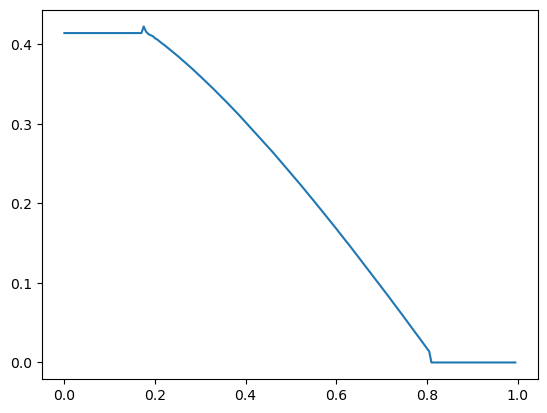

In [59]:
print(", ".join(map(str, dJUs)))
print(", ".join(map(str, muU_qcorr)))
plt.plot(dJUs, muU_qcorr, label=r"$\omega_{0}$")
plt.show()

In [17]:

from scipy.linalg import inv
from scipy.io import savemat
import numpy as np
import os
import utils
from grid import Grid
from params import Params
from gs import groundstate
from exc import excitations
from vert import vertices
from pert import perturbative
from class_self_energy import Self_Energy
from plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt

config_path = "config.yml" 

output_dir = utils.create_output_dir()

config = utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]

N = config["physics"]["N"]
dJUs = np.arange(**config["lists"]["dJUs"])
muU = eval(config["physics"]["muU"])
UIB = config["physics"]["UIB"]
cutoff = config["physics"]["cutoff"]

grid = Grid(Lx, Ly)
M = grid.M

dJU = 0.179
params = Params(N, dJU, muU, UIB, cutoff)
gs = groundstate(params)
cns = gs.cns()
n0 = gs.n0(cns)
psi0 = gs.psi0(cns)
exc = excitations(grid, params, gs, cns)
uks, vks, omegaklambda = exc.calculate_matrices()
verts = vertices(grid, gs, uks, vks, cns, n0)

en_vector = np.linspace(0.1, 0.3, 20)
dJU = 0.10099999999999998
Epol = en_vector[8]
print(Epol)
self_energy = Self_Energy(Epol, grid, params, verts, omegaklambda)
eta = 0.0001
dim = grid.M * N
U_mat = UIB * verts.U_mat()
V_mat = UIB * verts.V_mat()
W_mat = UIB * (verts.W_mat() + verts.W_mat().T)
omega_vec = self_energy.omega_vec()
epsI_vec = self_energy.epsI_vec()
Den1 = Epol - omega_vec - dJU * epsI_vec + eta * 1j
Den1 = np.tile(Den1, (dim,1))

omega_mat = omega_vec[:, np.newaxis] + omega_vec[np.newaxis, :]
epsI_grid = self_energy.eps_grid()
Den2 = Epol - omega_mat - dJU * epsI_grid + eta * 1j

IMat = np.eye(len(Den1))

# Den1 = self_energy.delete_elements(Den1, np.arange(1,100), axis = 0)
# U_mat =  self_energy.delete_elements(U_mat, np.arange(1,100), axis = 0)

Den1 = self_energy.delete_elements(Den1, np.arange(1,100), axis = 0)
Den2 = self_energy.delete_elements(Den2, np.arange(1,100), axis = 0)
U_mat = self_energy.delete_elements(U_mat, np.arange(1,100), axis = 0)
V_mat = self_energy.delete_elements(V_mat, np.arange(1,100), axis = 0)
W_mat = self_energy.delete_elements(W_mat, np.arange(1,100), axis = 0)

Pair_Prop_11_12 = np.divide(U_mat, Den1) / M
Pair_Prop_21_22 = np.divide(W_mat, Den1) / M
Pair_Prop_12_SE = np.divide(U_mat, Den2) / M
Pair_Prop_22_SE = np.divide(W_mat, Den2) / M

Pair_Prop_11_12[0:, 0] = 0
Pair_Prop_21_22[0:, 0] = 0
Pair_Prop_12_SE[0:, 0] = 0
Pair_Prop_22_SE[0:, 0] = 0

Pair_Prop_11_12[0, 0:] = 0
Pair_Prop_21_22[0, 0:] = 0
Pair_Prop_12_SE[0, 0:] = 0
Pair_Prop_22_SE[0, 0:] = 0

IMat = np.eye(len(Den1))

inv11 = inv(IMat - Pair_Prop_11_12)
T_11 = inv11 @ U_mat
T_12 = inv11 @ W_mat
T_21 = W_mat + Pair_Prop_21_22 @ T_11
T_22 = V_mat + Pair_Prop_21_22 @ T_12


inv12 = inv(IMat - Pair_Prop_12_SE)
T_12_SE = inv12 @ W_mat
T_22_SE = V_mat + 0.5 * Pair_Prop_22_SE @ T_12_SE

T22_diag = np.diag(T_22_SE)
Sigma_22 = sum(T22_diag[100:]) / grid.M

# Pair_Prop_11_12[0:99, 1:] = 0

savemat('mats/T_11.mat', {'T_11': T_11})
savemat('mats/PP.mat', {'PP': Pair_Prop_11_12})
savemat('mats/PP2.mat', {'PP2': Pair_Prop_22_SE})
savemat('mats/PP3.mat', {'PP3': Pair_Prop_12_SE})
savemat('mats/inv12.mat', {'inv12': inv12})

savemat('mats/U.mat', {'U': U_mat})
savemat('mats/V.mat', {'V': V_mat})
savemat('mats/W.mat', {'W': W_mat})
savemat('mats/Den1.mat', {'Den1': Den1})
savemat('mats/Den2.mat', {'Den2': Den2})

savemat('mats/T_12.mat', {'T_12': T_12})
savemat('mats/T_21.mat', {'T_21': T_21})
savemat('mats/T_22.mat', {'T_22': T_22})
savemat('mats/T_12_SE.mat', {'T_12_SE': T_12_SE})
savemat('mats/T_22_SE.mat', {'T_22_SE': T_22_SE})
print(Sigma_22)

0.1842105263157895
(-0.0053624070403587-4.961984931316922e-07j)


/Users/ragheed/micromamba/envs/boselattice/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ragheed/micromamba/envs/boselattice/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


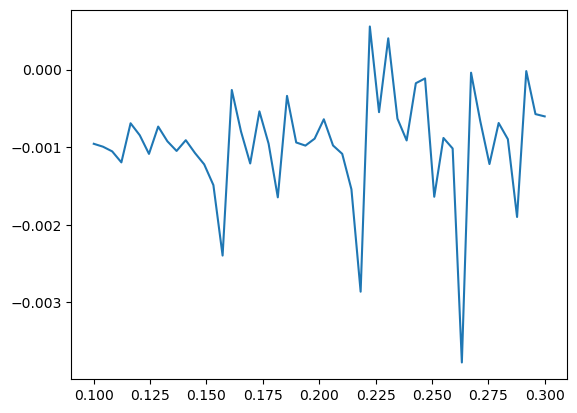

In [59]:
plt.plot(en_vector,T22_F[11, :])

In [21]:
M = grid.M
dim = Lx * Ly * N
KXs = grid.KXs
KYs = grid.KYs
# Us = np.zeros((dim, N))

PI1100 = np.zeros((dim, dim), dtype=complex)
PI1121 = np.zeros((dim, dim), dtype=complex)
PI21 = np.zeros((dim, dim), dtype=complex)
PI12 = np.zeros((dim, dim), dtype=complex)
PI2200 = np.zeros((dim, dim), dtype=complex)
PI22 = np.zeros((dim, dim), dtype=complex)
inv11 = np.zeros((dim, dim), dtype=complex)
inv12 = np.zeros((dim, dim), dtype=complex)
inv22 = np.zeros((dim, dim), dtype=complex)
T1100 = np.zeros((dim, dim), dtype=complex)
T1200 = np.zeros((dim, dim), dtype=complex)
T1121 = np.zeros((dim, dim), dtype=complex)
T1222 = np.zeros((dim, dim), dtype=complex)
T2100 = np.zeros((dim, dim), dtype=complex)
T2200 = np.zeros((dim, dim), dtype=complex)
T12 = np.zeros((dim, dim), dtype=complex)
T22 = np.zeros((dim, dim), dtype=complex)
Us = np.zeros((dim, dim))
Vs = np.zeros((dim, dim))
Ws = np.zeros((dim, dim))
den_mat = np.zeros((dim, dim), dtype=complex)
den_mat2 = np.zeros((dim, dim), dtype=complex)
en = np.zeros(len(en_vector), dtype=complex)
eps_mat = np.zeros((dim, dim), dtype=complex)


for lambda_ in range(N):
    for kx in range(Lx):
        for ky in range(Ly):
            for lambda1 in range(N):
                for qx in range(Lx):
                    for qy in range(Ly):
                        indk = lambda_ * Lx * Lx + kx * Ly + ky
                        indq = lambda1 * Lx * Ly + qx * Ly + qy
                        Uelem = UIB * verts.U(kx, ky, lambda_, qx, qy, lambda1)
                        if indk == 0 and indq == 0:
                            print(Uelem)
                        
                        Velem = UIB * verts.V(kx, ky, lambda_, qx, qy, lambda1)
                        Welem = UIB * (verts.W(kx, ky, lambda_, qx, qy, lambda1) + verts.W(qx, qy, lambda1, kx, ky, lambda_))
                        Den11 = Epol - omegaklambda[lambda1, qx, qy] - dJU * self_energy.epsI(KXs[qx], KYs[qy]) + eta * 1j
                        den_mat[indk, indq] = Den11
                        
                        Den22 = Epol - omegaklambda[lambda1, qx, qy] - dJU * self_energy.epsI(KXs[qx], KYs[qy]) + eta * 1j
                        
                        epsplus = self_energy.epsI(KXs[kx] + KXs[qx], KXs[ky] + KXs[qy])

                        # if lambda1 == 0:
                        #     epsplus = self_energy.epsI(KXs[kx], KXs[ky])

                        # if lambda_ == 0:
                        #     epsplus = self_energy.epsI(KXs[qx], KXs[qy])
                        Den = Epol - omegaklambda[lambda_, kx, ky] - omegaklambda[lambda1, qx, qy] - dJU * epsplus + eta * 1j
                        den_mat2[indk, indq] = Den
                        eps_mat[indk, indq] = epsplus
                        Us[indk, indq] = Uelem
                        # if indk < 2 and indq < 2:
                        #     print("after mat ", Us[0, 0])
                        Vs[indk, indq] = Velem
                        Ws[indk, indq] = Welem
                        coeff = 1.0 / M
                        PI1100[indk, indq] = coeff * (Uelem / Den11)
                        PI1100[indk, indq] = coeff * (Uelem / Den11)
                        PI1121[indk, indq] = coeff * (Uelem / Den22)
                        PI21[indk, indq] = coeff * (Welem / Den22)
                        PI2200[indk, indq] = coeff * (Welem / Den22)
                        PI12[indk, indq] = coeff * (Uelem / Den)
                        PI22[indk, indq] = coeff * (Welem / Den)
                        if lambda1 == 0:
                            # print("indk, indq ", indk, indq)
                            PI1100[indk, indq] = 0
                            PI1121[indk, indq] = 0
                            PI21[indk, indq] = 0
                            PI12[indk, indq] = 0
                            PI2200[indk, indq] = 0
                            PI22[indk, indq] = 0
# print("after for ", Us[0,0])
IMat = np.eye(dim)

inv11 = inv(IMat - PI1100)
inv22 = inv(IMat - PI1121)
T1100 = inv11 @ Us
T1200 = inv11 @ Ws
T1121 = inv22 @ Us
T2100 = Ws + PI21 @ T1121
T1222 = inv22 @ Ws
T2200 = Vs + PI21 @ T1222
inv12 = inv(IMat - PI12)
T12 = inv12 @ Ws
T22 = Vs + 0.5 * PI22 @ T12
T22diag = np.diag(T22)
Sigma22 = 0
for lambda_ in range(1, N):
    for kx in range(Lx):
        for ky in range(Ly):
            indk = lambda_ * M + kx * Lx + ky
            Sigma22 += 1.0 / M * T22diag[indk]
# en[epol_ind] = T1100[0,0]

# savemat('mats/T_11_lo.mat', {'T_11_lo': T1100})
# savemat('mats/PP_lo.mat', {'PP_lo': PI1100})
# savemat('mats/U_lo.mat', {'U_lo': Us})
savemat('mats/V_lo.mat', {'V_lo': Vs})
savemat('mats/W_lo.mat', {'W_lo': Ws})
savemat('mats/den_mat_lo.mat', {'den_mat_lo': den_mat})
savemat('mats/den_mat2_lo.mat', {'den_mat2_lo': den_mat2})
savemat('mats/T_12_lo.mat', {'T_12_lo': T1200})
savemat('mats/T_21_lo.mat', {'T_21_lo': T2100})
savemat('mats/T_22_lo.mat', {'T_22_lo': T2200})
savemat('mats/T_22_SE_lo.mat', {'T_22_SE_lo': T22})
print(Sigma22)

0.20007020270957943
(-0.004880384981890347-9.709675326960426e-07j)


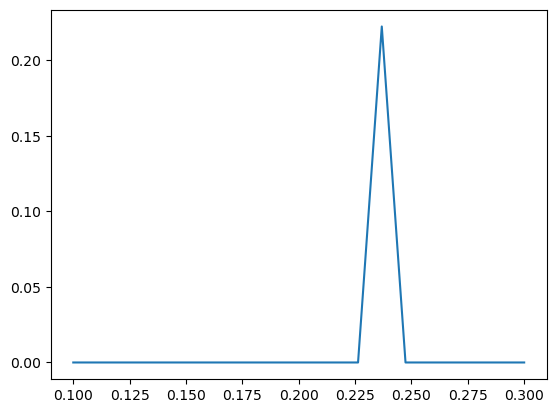

In [9]:
plt.plot(en_vector, np.real(en))

In [157]:
M = grid.M
dim = Lx * Ly * N

def U(kx, ky, lambda_, qx, qy, lambda1, uks, n0):
    Ures = 0
    ns = np.arange(0, N, 1)
    Ures = sum( (ns - n0 * (1 - (lambda_ == lambda1) * (lambda_ == 0))) * 
        uks[:, kx, ky, lambda_]
        * uks[:, qx, qy, lambda1]
    )
    return Ures

Us = np.zeros((dim, dim))
eps_mat = np.zeros((dim, dim))
for lambda_ in range(N):
    for kx in range(Lx):
        for ky in range(Ly):
            for lambda1 in range(N):
                for qx in range(Lx):
                    for qy in range(Ly):
                        indk = lambda_ * Lx * Lx + kx * Ly + ky
                        indq = lambda1 * Ly * Ly + qx * Ly + qy
                        Uelem = U(kx, ky, lambda_, qx, qy, lambda1, uks, n0)
                        Us[indq, indk] = Uelem
                        eps_mat[indq, indk] = epsI(grid.KXs[kx] + grid.KXs[qx], grid.KXs[ky] + grid.KXs[qy])
print(Us.shape)

(1200, 1200)


In [104]:
from scipy.io import savemat
U_2d_R = nss * uks_2d.T
U_2d_L = uks_2d
# Save the 2D array 'Us' to a .mat file
savemat('Us.mat', {'Us': Us})
savemat('U_2d.mat', {'U_2d': U_2d})
savemat('U_2d_R.mat', {'U_2d_R': U_2d_R})
savemat('U_2d_L.mat', {'U_2d_L': U_2d_L})

In [ ]:
value = exc.epsI(grid.KXs, grid.KYs)
matrix = np.full((len(grid.KXs), len(grid.KYs)), value)
# print(matrix)
matrix = exc.epsI(grid.KXs[:, None], grid.KYs[None, :])

matrix1 = np.zeros((cutoff, len(grid.KXs), len(grid.KYs)))
for lambda1 in range(cutoff):
    for i in range(len(grid.KXs)):
        for j in range(len(grid.KYs)):
            matrix1[lambda1][i][j] = Epol - omegaklambda[lambda1, i, j] - dJU * exc.epsI(grid.KXs[i], grid.KYs[j]) 
print(matrix1 - matrix)